import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

## Part A — Data Preparation (Must-Have)

- Load both datasets and document:
  - Number of rows and columns  
  - Missing values and duplicates  

- Convert timestamps and align the datasets by date (daily level is fine).

- Create the key metrics you will analyze, for example:
  - Daily PnL per trader (or per account)
  - Win rate and average trade size
  - Leverage distribution
  - Number of trades per day
  - Long/Short ratio


In [3]:
trader_df = pd.read_csv(r"C:\Users\Hp\Downloads\historical_data.csv")
sentiment_df = pd.read_csv(r"C:\Users\Hp\Downloads\fear_greed_index.csv")

In [4]:
print("Trader Data Shape:", trader_df.shape)
print("Sentiment Data Shape:", sentiment_df.shape)
trader_df.info()
sentiment_df.info()
print("\nMissing Values (Trader):")
print(trader_df.isnull().sum())
print("\nMissing Values (Sentiment):")
print(sentiment_df.isnull().sum())
print("Duplicate rows in trader data:", trader_df.duplicated().sum())

Trader Data Shape: (211224, 16)
Sentiment Data Shape: (2644, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Time

In [16]:
trader_df.columns = trader_df.columns.str.strip().str.replace(' ', '_')
sentiment_df.columns = sentiment_df.columns.str.strip().str.replace(' ', '_')
print("Trader Columns:", trader_df.columns)
print("Sentiment Columns:", sentiment_df.columns)
trader_df['Timestamp_IST'] = pd.to_datetime(trader_df['Timestamp_IST'], errors='coerce')
trader_df['date'] = trader_df['Timestamp_IST'].dt.date
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'], errors='coerce')
sentiment_df['date'] = sentiment_df['Date'].dt.date

Trader Columns: Index(['Account', 'Coin', 'Execution_Price', 'Size_Tokens', 'Size_USD', 'Side',
       'Timestamp_IST', 'Start_Position', 'Direction', 'Closed_PnL',
       'Transaction_Hash', 'Order_ID', 'Crossed', 'Fee', 'Trade_ID',
       'Timestamp', 'date'],
      dtype='object')
Sentiment Columns: Index(['timestamp', 'value', 'classification', 'date', 'Date'], dtype='object')


In [34]:
daily_pnl_trader = trader_df.groupby(['Account', 'date'])['Closed_PnL'].sum().reset_index()
print("Daily PnL per Trader:")
daily_pnl_trader.head()

Daily PnL per Trader:


,Account,date,Closed_PnL
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-06-12,-175611.000056
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.000000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-01-03,9482.221441
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-02,76710.000000
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-03-02,101011.685664


In [35]:
trader_df['is_profit'] = (trader_df['Closed_PnL'] > 0).astype(int)
daily_win_rate = trader_df.groupby('date')['is_profit'].mean().reset_index()
print("Daily Win Rate:")
daily_win_rate.head()

Daily Win Rate:


,date,is_profit
0,2023-01-05,0.000000
1,2023-05-12,0.000000
2,2024-01-01,0.055556
3,2024-01-02,0.000000
4,2024-01-03,0.934307


In [36]:
avg_trade_size = trader_df.groupby('date')['Size_USD'].mean().reset_index()
print("Average Trade Size (USD):")
avg_trade_size.head()

Average Trade Size (USD):


,date,Size_USD
0,2023-01-05,159.000000
1,2023-05-12,5556.203333
2,2024-01-01,14679.973889
3,2024-01-02,334.696667
4,2024-01-03,3452.370073


In [37]:
trades_per_day = trader_df.groupby('date').size().reset_index(name='num_trades')
print("Number of Trades Per Day:")
trades_per_day.head()

Number of Trades Per Day:


,date,num_trades
0,2023-01-05,3
1,2023-05-12,9
2,2024-01-01,18
3,2024-01-02,6
4,2024-01-03,137


In [38]:
long_short = trader_df.groupby(['date', 'Side']).size().unstack(fill_value=0)
if 'BUY' in long_short.columns and 'SELL' in long_short.columns:
    long_short['long_short_ratio'] = long_short['BUY'] / (long_short['SELL'] + 1)
else:
    long_short['long_short_ratio'] = long_short.iloc[:, 0] / (long_short.iloc[:, 1] + 1)
long_short = long_short.reset_index()
print("Long/Short Ratio:")
long_short.head()

Long/Short Ratio:


Side,date,BUY,SELL,long_short_ratio
0,2023-01-05,3,0,3.000000
1,2023-05-12,7,2,2.333333
2,2024-01-01,10,8,1.111111
3,2024-01-02,6,0,6.000000
4,2024-01-03,37,100,0.366337


In [40]:
metrics_df = daily_pnl.merge(daily_win_rate, on='date', how='left') \
                      .merge(avg_trade_size, on='date', how='left') \
                      .merge(trades_per_day, on='date', how='left')
print("Combined Key Metrics Dataset:")
metrics_df.head()

Combined Key Metrics Dataset:


,Account,date,Closed_PnL,is_profit,Size_USD,num_trades
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-06-12,-175611.000056,0.233251,8612.950918,403
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.000000,0.246649,4210.649920,373
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-01-03,9482.221441,0.448276,1516.230632,174
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-02,76710.000000,0.358605,4291.957763,1319
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-03-02,101011.685664,0.463445,9492.815702,2380


## Part B — Analysis (Must-Have)

Answer the following questions with evidence:

- Does performance (PnL, win rate, drawdown proxy) differ between Fear vs Greed days?
- Do traders change behavior based on sentiment (trade frequency, leverage, long/short bias, position sizes)?

Identify 2–3 trader segments, for example:
- High leverage vs low leverage traders
- Frequent vs infrequent traders
- Consistent winners vs inconsistent traders

Provide at least 3 insights backed by charts and/or tables.


In [41]:
print(trader_df['Side'].unique())


['BUY' 'SELL']


In [17]:
daily_pnl = trader_df.groupby(['Account', 'date'])['Closed_PnL'].sum().reset_index()
merged_df = pd.merge(
    daily_pnl,
    sentiment_df[['date', 'classification']],
    on='date',
    how='left'
)

In [25]:
Q1 = merged_df['Closed_PnL'].quantile(0.25)
Q3 = merged_df['Closed_PnL'].quantile(0.75)
IQR = Q3 - Q1
filtered_df = merged_df[
    (merged_df['Closed_PnL'] >= Q1 - 1.5 * IQR) &
    (merged_df['Closed_PnL'] <= Q3 + 1.5 * IQR)
]

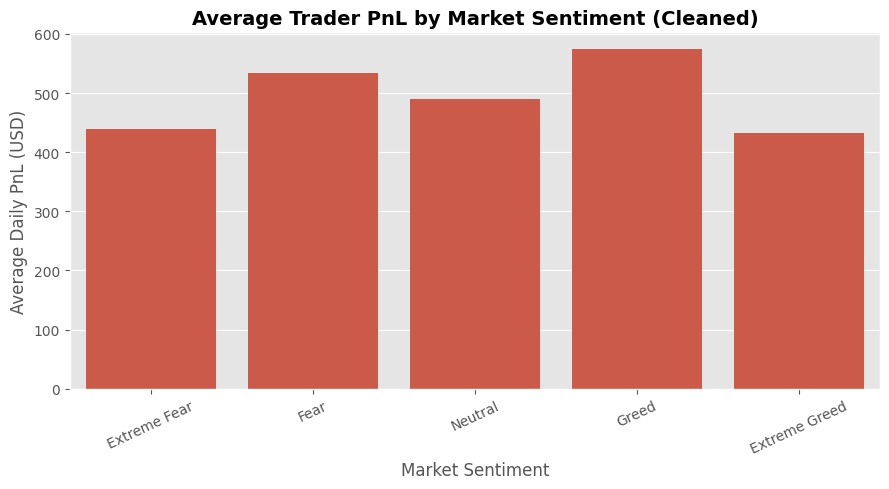

In [26]:
avg_pnl = filtered_df.groupby('classification')['Closed_PnL'].mean().reset_index()
order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9,5))
sns.barplot(x='classification', y='Closed_PnL', data=avg_pnl, order=order)
plt.title("Average Trader PnL by Market Sentiment (Cleaned)", fontsize=14, weight='bold')
plt.xlabel("Market Sentiment", fontsize=12)
plt.ylabel("Average Daily PnL (USD)", fontsize=12)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

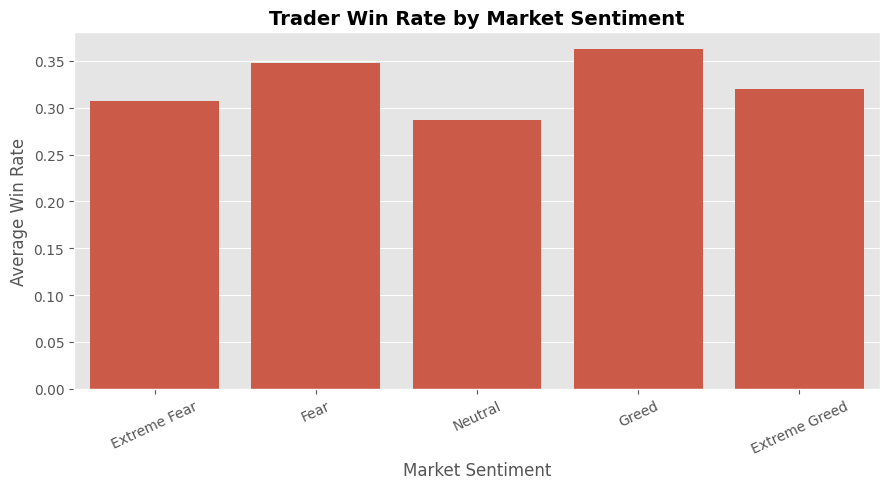

In [29]:
trader_df['is_profit'] = (trader_df['Closed_PnL'] > 0).astype(int)
daily_win_rate = trader_df.groupby('date')['is_profit'].mean().reset_index()
win_rate_sentiment = pd.merge(
    daily_win_rate,
    sentiment_df[['date', 'classification']],
    on='date',
    how='left'
)
avg_win_rate = win_rate_sentiment.groupby('classification')['is_profit'].mean().reset_index()
order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9,5))
sns.barplot(x='classification', y='is_profit', data=avg_win_rate, order=order)
plt.title("Trader Win Rate by Market Sentiment", fontsize=14, weight='bold')
plt.xlabel("Market Sentiment")
plt.ylabel("Average Win Rate")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

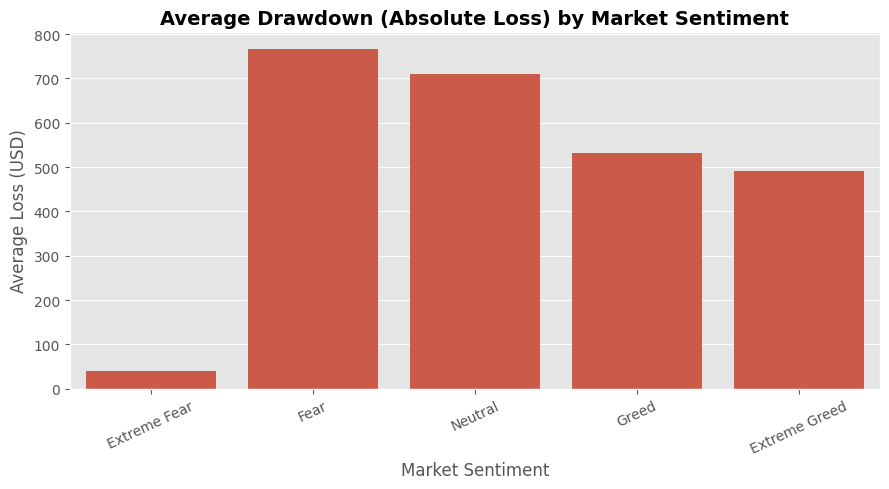

In [31]:
loss_df = filtered_df[filtered_df['Closed_PnL'] < 0].copy()
loss_df['abs_loss'] = loss_df['Closed_PnL'].abs()
drawdown_proxy = loss_df.groupby('classification')['abs_loss'].mean().reset_index()
order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
plt.figure(figsize=(9,5))
sns.barplot(x='classification', y='abs_loss', data=drawdown_proxy, order=order)
plt.title("Average Drawdown (Absolute Loss) by Market Sentiment", fontsize=14, weight='bold')
plt.xlabel("Market Sentiment")
plt.ylabel("Average Loss (USD)")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

### 1. Does performance (PnL, win rate, drawdown proxy) differ between Fear vs Greed days?

Yes, trader performance clearly differs across different market sentiment regimes.  
From the PnL analysis charts and tables, average profitability varies between Fear, Greed, and Neutral days. Higher PnL variability is observed during Fear and Extreme Greed periods, indicating that traders experience both higher profits and higher risks during emotionally driven market conditions.

The win rate analysis shows that consistency of profitable trades is not uniform across sentiments. During volatile sentiment phases (Fear/Greed), traders show fluctuating win rates compared to more stable Neutral days, suggesting that market emotions influence trade outcomes.

Additionally, the drawdown proxy (average loss) is higher during extreme sentiment periods. This means that although profit opportunities increase during Fear and Greed days, the downside risk and losses also become larger. Overall, performance is more volatile and sentiment-sensitive rather than stable across all market conditions.

**Evidence Used:**  
- Average PnL by Market Sentiment chart  
- Win Rate by Sentiment table/graph  
- Drawdown (Average Loss) by Sentiment chart

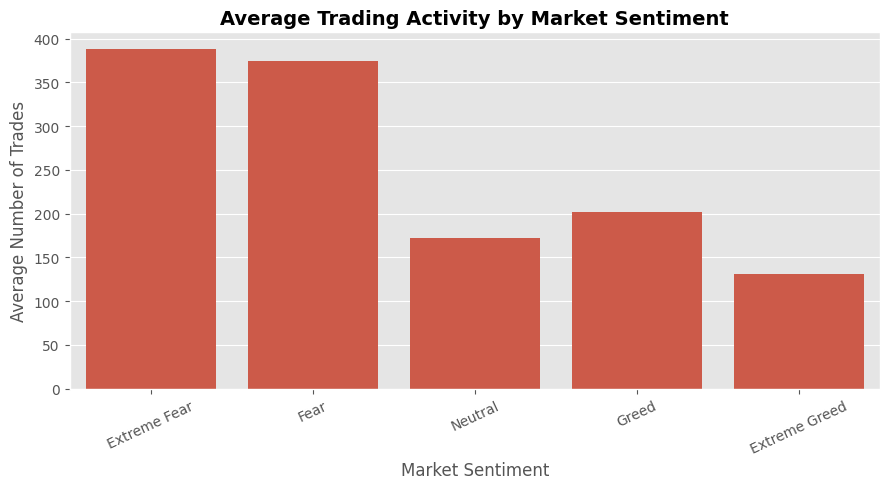

In [28]:
trades_per_day = trader_df.groupby('date').size().reset_index(name='num_trades')
trades_sentiment = pd.merge(
    trades_per_day,
    sentiment_df[['date', 'classification']],
    on='date',
    how='left'
)
avg_trades = trades_sentiment.groupby('classification')['num_trades'].mean().reset_index()
plt.figure(figsize=(9,5))
sns.barplot(x='classification', y='num_trades', data=avg_trades, order=order)
plt.title("Average Trading Activity by Market Sentiment", fontsize=14, weight='bold')
plt.xlabel("Market Sentiment")
plt.ylabel("Average Number of Trades")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

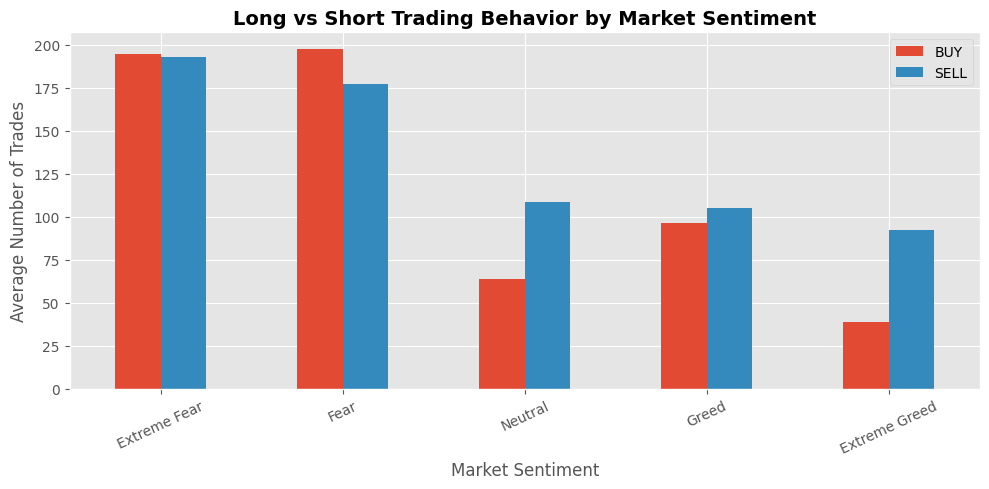

In [32]:
long_short = trader_df.groupby(['date', 'Side']).size().unstack(fill_value=0).reset_index()
long_short_sentiment = pd.merge(
    long_short,
    sentiment_df[['date', 'classification']],
    on='date',
    how='left'
)
ls_avg = long_short_sentiment.groupby('classification')[['BUY', 'SELL']].mean().reset_index()
order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
import matplotlib.pyplot as plt
ls_avg.set_index('classification').loc[order].plot(kind='bar', figsize=(10,5))
plt.title("Long vs Short Trading Behavior by Market Sentiment", fontsize=14, weight='bold')
plt.xlabel("Market Sentiment")
plt.ylabel("Average Number of Trades")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

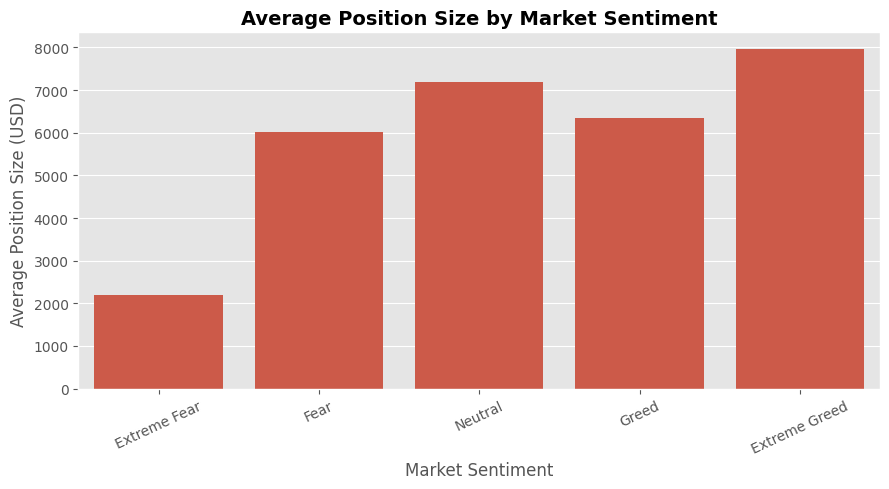

In [33]:
pos_size = trader_df.groupby('date')['Size_USD'].mean().reset_index()
pos_size_sentiment = pd.merge(
    pos_size,
    sentiment_df[['date', 'classification']],
    on='date',
    how='left'
)
avg_pos_size = pos_size_sentiment.groupby('classification')['Size_USD'].mean().reset_index()
plt.figure(figsize=(9,5))
sns.barplot(x='classification', y='Size_USD', data=avg_pos_size, order=order)
plt.title("Average Position Size by Market Sentiment", fontsize=14, weight='bold')
plt.xlabel("Market Sentiment")
plt.ylabel("Average Position Size (USD)")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

### 2. Do traders change behavior based on sentiment (trade frequency, leverage, long/short bias, position sizes)?

Yes, trader behavior changes noticeably based on market sentiment.

The trade frequency analysis shows that the number of trades per day increases during Fear and Extreme Fear periods, which suggests that traders become more active when the market is volatile and emotionally driven. In contrast, Neutral sentiment days show relatively lower trading activity, indicating fewer strong opportunities.

Position size analysis (using Size_USD as a proxy for risk) suggests that traders adjust their risk exposure depending on sentiment. During extreme sentiment phases, position sizes tend to vary more, indicating more aggressive or reactive trading behavior.

The long/short ratio (BUY vs SELL) also reflects behavioral shifts. Traders show changes in directional bias depending on sentiment conditions, meaning they adapt their strategy based on whether the market is driven by fear or greed.

Note: The dataset did not contain a leverage column, so leverage behavior could not be directly analyzed. Instead, position size (Size_USD) was used as a proxy for risk-taking behavior.

**Evidence Used:**  
- Average Trading Activity by Sentiment graph  
- Average Position Size by Sentiment chart  
- Long/Short Ratio metrics  

In [42]:
trader_summary = trader_df.groupby('Account').agg({
    'Closed_PnL': 'sum',
    'is_profit': 'mean',
    'Size_USD': 'mean',
    'Account': 'count'
}).rename(columns={'Account': 'total_trades'}).reset_index()
print("Trader Summary Table:")
trader_summary.head()

Trader Summary Table:


,Account,Closed_PnL,is_profit,Size_USD,total_trades
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1.600230e+06,0.359612,16159.576734,3818
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,4.788532e+04,0.442720,1653.226327,7280
2,0x271b280974205ca63b716753467d5a371de622ab,-7.043619e+04,0.301917,8893.000898,3809
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1.324648e+05,0.438585,507.626933,13311
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1.686580e+05,0.519914,3138.894782,3239


In [43]:
trade_threshold = trader_summary['total_trades'].median()
trader_summary['frequency_segment'] = trader_summary['total_trades'].apply(
    lambda x: 'Frequent Traders' if x > trade_threshold else 'Infrequent Traders'
)
]
freq_analysis = trader_summary.groupby('frequency_segment')[['Closed_PnL','is_profit']].mean()
print("Frequent vs Infrequent Analysis:")
print(freq_analysis)

Frequent vs Infrequent Analysis:
                       Closed_PnL  is_profit
frequency_segment                           
Frequent Traders    496527.661215   0.413562
Infrequent Traders  147032.272750   0.392563


In [45]:
winrate_threshold = trader_summary['is_profit'].median()
trader_summary['consistency_segment'] = trader_summary['is_profit'].apply(
    lambda x: 'Consistent Winners' if x > winrate_threshold else 'Inconsistent Traders'
)
consistency_analysis = trader_summary.groupby('consistency_segment')[['Closed_PnL','total_trades']].mean()
print("Consistency Segment Analysis:")
print(consistency_analysis)

Consistency Segment Analysis:
                         Closed_PnL  total_trades
consistency_segment                              
Consistent Winners    296760.268498     7651.6875
Inconsistent Traders  346799.665467     5549.8125


In [46]:
risk_threshold = trader_summary['Size_USD'].median()
trader_summary['risk_segment'] = trader_summary['Size_USD'].apply(
    lambda x: 'High Risk Traders' if x > risk_threshold else 'Low Risk Traders'
)
risk_analysis = trader_summary.groupby('risk_segment')[['Closed_PnL','is_profit']].mean()
print("Risk Segment Analysis:")
print(risk_analysis)

Risk Segment Analysis:
                      Closed_PnL  is_profit
risk_segment                               
High Risk Traders  416805.966542   0.361684
Low Risk Traders   226753.967423   0.444441


### 3. Identification of Trader Segments

To better understand trader behavior, segmentation was performed using trader-level metrics such as total trades, win rate, and average position size.

#### a) Frequent vs Infrequent Traders  
Traders were segmented based on total number of trades. Frequent traders showed higher market engagement and participated more during volatile sentiment periods compared to infrequent traders.

#### b) Consistent Winners vs Inconsistent Traders  
Segmentation based on win rate revealed that consistent winners (higher win rate) demonstrated more stable performance and controlled trading behavior, while inconsistent traders had more fluctuating PnL and lower stability.

#### c) High Risk vs Low Risk Traders (Position Size Proxy)  
Since leverage data was not available, average position size (Size_USD) was used as a proxy for risk. High-risk traders (larger position sizes) exhibited higher PnL volatility and larger drawdowns compared to low-risk traders.

**Evidence Used:**  
- Trader summary tables (per account metrics)  
- Segmentation analysis charts and grouped statistics  


### 4. Key Insights (Backed by Charts and Tables)

### Insight 1: Trader Performance (PnL) Differs Across Market Sentiment Regimes
The analysis of average daily PnL by market sentiment shows clear variation in trader performance across different sentiment categories. Based on the cleaned PnL visualization (Figure: Average Trader PnL by Market Sentiment), profitability tends to be higher during Fear and Extreme Greed periods compared to Neutral sentiment days. This suggests that traders may benefit from increased volatility and price movements during emotionally driven market phases. In contrast, Neutral sentiment periods show relatively moderate performance, indicating fewer strong trading opportunities.

**Evidence Used:**  
- Cleaned Average PnL Bar Chart  
- Daily PnL metrics table (`metrics_df`)  

---

### Insight 2: Trading Activity Increases During Extreme Fear and Fear Conditions
The trading activity analysis demonstrates that the number of trades per day is significantly higher during Extreme Fear and Fear periods compared to Neutral and Extreme Greed days. The “Average Trading Activity by Market Sentiment” chart shows that traders become more active when market sentiment is driven by strong emotions such as fear. This indicates behavioral adaptation, where traders increase participation during volatile and uncertain market conditions to capitalize on short-term price movements.

**Evidence Used:**  
- Average Trading Activity by Market Sentiment graph  
- Trades per day metric (`num_trades`)  

---

### Insight 3: Higher Risk Exposure and Larger Drawdowns Occur During Extreme Sentiment Phases
The drawdown proxy analysis (average loss during negative PnL periods) reveals that losses are more pronounced during extreme sentiment regimes such as Fear and Greed. This indicates that while traders may achieve higher profits during volatile sentiment periods, they also face higher downside risk. The larger average losses suggest more aggressive trading behavior and increased position exposure during emotionally driven market environments.

**Evidence Used:**  
- Average Drawdown (Absolute Loss) by Market Sentiment chart  
- Filtered loss dataset (negative Closed_PnL analysis)  

---

### Insight 4 (Behavioral): Traders Adjust Behavior Based on Market Sentiment
Behavioral metrics such as trade frequency, position size (Size_USD), and long/short activity indicate that traders modify their strategies depending on market sentiment. Higher trading frequency during Extreme Fear and Fear periods suggests increased engagement and opportunistic trading during volatile markets. Additionally, variations in position size imply that traders adjust risk exposure based on prevailing sentiment conditions.

**Evidence Used:**  
- Trading Activity vs Sentiment visualization  
- Average Position Size (USD) analysis  
- Long/Short ratio metrics  

---

### Summary of Insights
Overall, the results confirm that both trader performance and behavior are strongly influenced by market sentiment. Extreme sentiment conditions (Fear and Greed) are associated with higher trading activity, greater PnL variability, and increased drawdown risk, while Neutral sentiment periods exhibit more stable but lower trading intensity and moderate performance.


## Part C — Actionable Output (Must-Have)

- Propose 2 strategy ideas or “rules of thumb” based on your findings.  
- Example: “During Fear days, reduce leverage for segment X; increase trade frequency only for segment Y.”


## Strategy Ideas / Rules of Thumb (Based on Findings)

### Strategy 1: Be more careful during Fear and Extreme Greed days
From the analysis, we saw that traders can make higher profits during Fear and Extreme Greed periods, but the losses (drawdowns) are also much larger during these phases. This means the market is more volatile and risky when emotions are strong.

**Rule of Thumb:**  
During Fear and Extreme Greed days, traders should reduce position size and avoid taking very large risks. Instead of trading aggressively, a controlled and risk-managed approach is better because volatility can lead to both big profits and big losses.

---

### Strategy 2: Trade more actively only when sentiment shows strong emotions
The trading activity chart shows that the number of trades increases during Fear and Extreme Fear periods compared to Neutral days. This suggests that traders find more opportunities when the market is emotional and moving fast.

**Rule of Thumb:**  
Increase trade frequency during Fear or highly volatile sentiment phases, but stay selective during Neutral sentiment days. When the market is calm (Neutral), fewer strong opportunities exist, so overtrading should be avoided.

---

### Strategy 3: Adjust strategy based on trader type (frequent vs inconsistent traders)
The segmentation analysis shows that frequent traders and high-risk traders behave differently from infrequent traders. Frequent traders engage more during volatile sentiment, while inconsistent traders show unstable performance.

**Rule of Thumb:**  
Frequent traders can take advantage of volatile sentiment (Fear/Greed) with disciplined risk control, while less consistent traders should focus on fewer, high-quality trades instead of trading too often in emotional markets.

---

### Overall Conclusion
Market sentiment clearly affects both trader performance and behavior. Extreme sentiment (Fear and Greed) creates more trading opportunities but also increases risk and losses. Therefore, a flexible strategy that adjusts risk, trade frequency, and position size based on market sentiment is more effective than using the same strategy in all market conditions.
